# Co-refinement of ellipsometry, X-ray reflectometry and neutron reflectometry data
This is a demonstration of how to co-refine data obtained from ellipsometry, neutron reflectometry (NR) and X-ray reflectometry (XRR) using both *refellips* and *refnx*. This notebook also demonstrates how to apply Lagrange multipliers to an individual `Objective` when constructing the `GlobalObjective`. This statistical approach may be employed to ensure that particular datasets have appropriate weightings during the co-refinement process.

The data analysed in this demonstration corresponds to a polymer film grafted onto an oxisided silicon wafer. All measurements were performed at ANSTO using an Accurion EP4, the Platypus time-of-flight neutron reflectometer and the Panalytical X'Pert Pro X-ray reflectometry, respectively.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
import refellips
from refellips.dataSE import open_EP4file
from refellips import ReflectModelSE, ObjectiveSE, load_material

In [3]:
import refnx
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import CurveFitter, Parameter, Objective, GlobalObjective, Transform
from refnx.reflect import Linear, Erf, SLD, ReflectModel

In [4]:
print(f'refellips: {refellips.version.version}\nrefnx: {refnx.version.version}\nscipy: {scipy.version.version}\nnumpy: {np.version.version}')

refellips: 0.0.1
refnx: 0.1.29.dev0+77a8105
scipy: 1.8.0
numpy: 1.22.3


# Load data

In [5]:
data_ellips = open_EP4file('corefine_PNIPAM_ellipsometry.dat')
data_xray = RD('corefine_PNIPAM_XRR.dat')
data_nr = RD('corefine_PNIPAM_NR.dat')

No time data.
Treating as single location


# Build model
First let's create global parameters which we will use for the polymer and silica thickness and roughness for each of the three models.

In [6]:
silica_thickness = Parameter(20, vary = True, bounds = (1,30), name='silica_thickness')
polymer_thickness = Parameter(250, vary = True, bounds = (150,400), name='polymer_thickness')

silica_roughness = Parameter(0.1, vary = True, bounds = (0.01,10), name='silica_roughness')
polymer_roughness = Parameter(10, vary = True, bounds = (0.01,20), name='polymer_roughness')

## Ellipsometry model

In [7]:
si     = load_material('silicon')
sio2   = load_material('silica')
PNIPAM = load_material('pnipam')
air    = load_material('air')

polymer_layer = PNIPAM(polymer_thickness, polymer_roughness)
polymer_layer.name = 'PNIPAM'

silica_layer = sio2(silica_thickness, silica_roughness)
silica_layer.name = 'Silica'

structure_ellips = air() | polymer_layer | silica_layer | si()
structure_ellips.contract = 1.5

model_ellips = ReflectModelSE(structure_ellips)

## X-ray reflectometry model

In [8]:
si     = SLD(20.1, 'silicon')
sio2   = SLD(22, 'silica')
PNIPAM = SLD(10.2, 'pnipam')
air    = SLD(0, 'air')

polymer_layer = PNIPAM(polymer_thickness, polymer_roughness)
polymer_layer.name = 'PNIPAM'
polymer_layer.sld.real.setp(vary=True, bounds=(9.5,11))

silica_layer = sio2(silica_thickness, silica_roughness)
silica_layer.name = 'Silica'
silica_layer.sld.real.setp(vary=True, bounds=(20,23))

structure_xray = air() | polymer_layer | silica_layer | si()
structure_xray.contract = 1.5

model_xray = ReflectModel(structure_xray)
model_xray.bkg.setp(vary=True, bounds=(1e-9, 5e-6))
model_xray.scale.setp(value=1, vary=True, bounds=(0.7, 1.1))

## Neutron reflectometry model

In [9]:
si     = SLD(2.07, 'silicon')
sio2   = SLD(3.47, 'silica')
PNIPAM = SLD(0.8, 'pnipam')
air    = SLD(0, 'air')

polymer_layer = PNIPAM(polymer_thickness, polymer_roughness)
polymer_layer.name = 'PNIPAM'
polymer_layer.sld.real.setp(vary=True, bounds=(0.5,0.9))

silica_layer = sio2(silica_thickness, silica_roughness)
silica_layer.name = 'Silica'
silica_layer.sld.real.setp(vary=False)

structure_nr = air() | polymer_layer | silica_layer | si()
structure_nr.contract = 1.5

model_nr = ReflectModel(structure_nr)
model_nr.bkg.setp(vary=True, bounds=(1e-9, 5e-6))
model_nr.scale.setp(value=1, vary=True, bounds=(0.9, 1.1))

# Create the objectives for each technique
For each of these three objectives, we will not weight the data. We will take this into account in the global objective. 

In [10]:
objective_ellips = ObjectiveSE(model_ellips, data_ellips, use_weights=False)
objective_xray = Objective(model_xray, data_xray, transform=Transform('logY'), use_weights=False)
objective_nr = Objective(model_nr, data_nr, transform=Transform('logY'), use_weights=False)

# Create the global objective
Here we create a global objective which includes the individual objectives for ellipsometry, X-ray reflectometry and neutron reflectometry. Here we also apply Lagrange multipliers (`lambdas`) to each objective such that each dataset has equal weighting on the negative log-likelihood. These lambda values are empirically derived and system dependent.

In [11]:
lambdas = [0.45, 0.95, 6.6] #[ellipsometry, XRR, NR]

In [12]:
global_objective = GlobalObjective([objective_ellips, objective_xray, objective_nr], lambdas=lambdas)

# Fit the data

In [13]:
fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution', target="nll");

52it [01:31,  1.77s/it]


# Optimised objectives and fit parameters

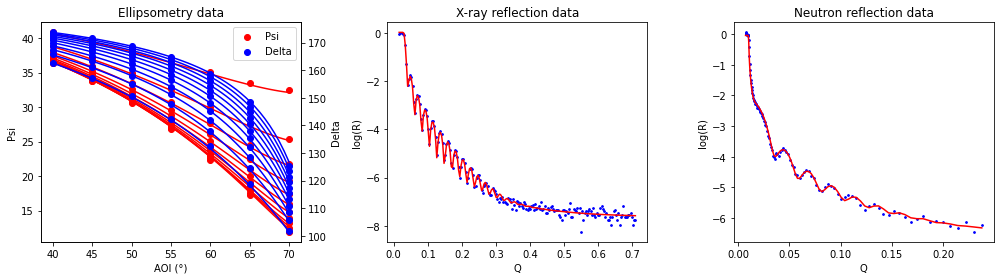

In [14]:
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(131)
objective_ellips.plot(fig=fig);
ax1.set_title('Ellipsometry data')

ax2 = fig.add_subplot(132)
objective_xray.plot(fig=fig);
ax2.set_xlabel('Q')
ax2.set_ylabel('log(R)')
ax2.set_title('X-ray reflection data')

ax3 = fig.add_subplot(133) 
objective_nr.plot(fig=fig);
ax3.set_xlabel('Q')
ax3.set_ylabel('log(R)')
ax3.set_title('Neutron reflection data')

fig.tight_layout()

In [15]:
for i, obj in enumerate(global_objective.objectives):
    print(obj.nll(np.array(obj.parameters)) * lambdas[i], obj.npoints)

1.966521846593163 77
1.9280532297886612 196
1.9679269477316412 111


In [16]:
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 140370616190096
Dataset = corefine_
datapoints = 77
chi2 = 8.740097095969613
Weighted = False
Transform = None
________________________________________________________________________________
Parameters:      None      
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed) 